In [79]:
! pip install rustworkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.1 MB/s eta 0:00:00


In [80]:
import torch
import weakref
import numbers
import rustworkx as rx

# custom Tensor

In [96]:
import torch

class CustomTensor:
    """
    CustomTensor(data, ...) will return the same object if `data` is already a CustomTensor.
    This avoids memory reallocation and graph duplication.
    Do not use it to rewrap or re-register nodes. Use only for symbolic reference.
    """
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph','__weakref__')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None,due_to_operation=False):
        if isinstance(data, CustomTensor):
            return data  # ✅ Prevent new allocation, return existing one
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None,due_to_operation=False):
        if isinstance(data, CustomTensor):
            # Already returned in __new__, skip init
            return
        if due_to_operation:
          self.tensor = data
        else:
          self.tensor = torch.as_tensor(data, dtype=dtype, device=device)
          self.tensor.requires_grad_(False)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None

        if _custom_requires_grad:
            self._init_graph(graph)

    def _init_graph(self, graph):
        if graph is None:
            raise ValueError("Graph must be provided when _custom_requires_grad is True.")
        self.graph = weakref.ref(graph)
        graph.add_tensor_graph(self)
        graph.add_non_leaf_tensor_references(self)
    def _zero_grad(self):
        self.tensor.grad = torch.zeros_like(self.tensor)

    def __add__(self,other):

        if isinstance(other, numbers.Number):
            result = Operations.add_tensor_and_scalar(self.tensor,other)
            requires_grad = self._custom_requires_grad
            if requires_grad:
                graph = self.graph()
                result = CustomTensor(result,_custom_requires_grad=True,graph=graph,due_to_operation=True)
                graph.add_edge(self._node_id, result._node_id)
                def _backward():
                    if self.tensor.grad is None:
                        self._zero_grad()
                    self.tensor.grad = Operations.add_tensor_and_tensor(self.tensor.grad,result.tensor.grad)
                result._backward = _backward
                return result
            else:
                return CustomTensor(result,_custom_requires_grad=requires_grad)
        elif isinstance(other,CustomTensor):
            result = Operations.add_tensor_and_tensor(self.tensor,other.tensor)
            self_requires_grad = self._custom_requires_grad
            other_requires_grad = other._custom_requires_grad
            if self_requires_grad and other_requires_grad:
                graph = self.graph()
                result = CustomTensor(result,_custom_requires_grad=True,graph=graph,due_to_operation=True)
                graph.add_edge(self._node_id, result._node_id)
                graph.add_edge(other._node_id, result._node_id)
                def _backward():
                    if self.tensor.grad is None:
                        self._zero_grad()
                    if other.tensor.grad is None:
                        other._zero_grad()
                    self.tensor.grad.add_(result.tensor.grad)
                    other.tensor.grad.add_(result.tensor.grad)
                result._backward = _backward
                return result
            elif self_requires_grad and not other_requires_grad:
                graph =self.graph()
                result = CustomTensor(result,_custom_requires_grad = True, graph=graph,due_to_operation=True)
                graph.add_edge(self._node_id,result._node_id)
                def _backward():
                    if self.tensor.grad is None:
                        self._zero_grad()
                    self.tensor.grad.add_(result.tensor.grad)# = Operations.add_tensor_and_tensor(self.tensor.grad,result.tensor.grad)
                result._backward =_backward
                return result
            elif other_requires_grad and not self_requires_grad:
                graph = other.graph()
                result = CustomTensor(result,_custom_requires_grad =True, graph = graph,due_to_operation=True)
                graph.add_edge(other._node_id,result._node_id)
                def _backward():
                    if other.tensor.grad is None:
                        other._zero_grad()
                    other.tensor.grad.add_(result.tensor.grad) #= Operations.add_tensor_and_tensor(other.tensor.grad,result.tensor.grad)
                result._backward =_backward
                return result
            else:
                return CustomTensor(result,_custom_requires_grad=False,graph=None,due_to_operation=True)
    def __del__(self):
        print(f"CustomTensor with id={id(self)} is being garbage collected")

# AutogradGraph

In [4]:
class AutogradGraph:
    def __init__(self,check_for_cycles=True, auto_cleanup=True):
        self.graph = rx.PyDiGraph()
        self.intermediate_tensors = dict()
        self._check_cycles = check_for_cycles
        self._auto_cleanup = auto_cleanup


    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._check_cycles:
            if not self.check_cycle():
                raise RuntimeError("Cycle detected in autograd graph on context exit.")
        if self._auto_cleanup:
            self.intermediate_tensors.clear()
            self.graph.clear()

    def add_tensor_graph(self, tensor):
        requires_grad = tensor._custom_requires_grad
        if not requires_grad:
            raise ValueError("Tensor with require grad False cannot to be added to the graph.")

        tensor_index = self.graph.add_node(weakref.ref(tensor))
        tensor._node_id  = tensor_index

    def add_non_leaf_tensor_references(self, tensor):
        requires_grad = tensor._custom_requires_grad

        node_id = tensor._node_id

        if not requires_grad:
            raise ValueError("Tensor must be a non leaf tensor.")

        if node_id in self.intermediate_tensors:
            raise ValueError("Tensor reference to persist in memory already exists.")

        self.intermediate_tensors[node_id] = tensor

    def add_edge(self, node_from, node_to, weight=None):
        if not isinstance(node_from, int) or not isinstance(node_to, int):
            raise TypeError("Node indices must be integers.")

        graph = self.graph
        if not graph.has_node(node_from) or not graph.has_node(node_to):
            raise ValueError("Both nodes must exist in the graph before adding an edge.")

        graph.add_edge(node_from, node_to, weight)

    def check_cycle(self):
        return rx.is_directed_acyclic_graph(self.graph)

    def reverse_toposort(self):

        if not self.check_cycle():
            raise RuntimeError("Cannot perform topological sort on a graph with cycles.")
        graph = self.graph
        node_indexes = rx.topological_sort(graph)
        return [graph[node_index] for node_index in reversed(node_indexes)]

    def delete_node(self, node_index):
        if not isinstance(node_index, int):
            raise TypeError("Node index must be an integer.")

        graph = self.graph
        if not graph.has_node(node_index):
            raise ValueError(f"Node index {node_index} does not exist in the graph.")

        graph.remove_node(node_index)

    def delete_edge(self, node_from, node_to):
        if not isinstance(node_from, int) or not isinstance(node_to, int):
            raise TypeError("Node indices must be integers.")

        graph = self.graph
        if not graph.has_edge(node_from, node_to):
            raise ValueError(f"Edge ({node_from}, {node_to}) does not exist in the graph.")

        graph.remove_edge(node_from, node_to)

    def del_non_leaf_tensor_reference(self, tensor_node_id):
        try:
            del self.intermediate_tensors[tensor_node_id]
        except KeyError:
            raise KeyError(f"No tensor reference found for node ID {tensor_node_id}")

    def __repr__(self):
        graph = self.graph
        return f"CustomAutogradGraph(nodes={graph.num_nodes()}, edges={graph.num_edges()})"



# Operations

In [82]:
class Operations:
    @torch.jit.script
    def add_tensor_and_scalar(tensor: torch.Tensor, scaler: float) -> torch.Tensor:
        return tensor + scaler

    @torch.jit.script
    def add_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
        return tensor1 + tensor2

# Tests

In [97]:
device = "cpu"
dtype =  torch.float16
a = CustomTensor([1,2,3],_custom_requires_grad=False,device="cpu",dtype=dtype,graph = None)

In [98]:
b = CustomTensor([-5,6.8,-3.5],_custom_requires_grad=False,device = device,dtype=dtype,graph = None)

In [93]:
b

In [94]:
a

In [121]:
a.tensor.grad

tensor([0., 0., 0.], dtype=torch.float16)

In [120]:
a._zero_grad()

In [122]:
a.tensor.grad.add_(1)

tensor([1., 1., 1.], dtype=torch.float16)

In [115]:
c=a+b

In [116]:
c.tensor

tensor([-4.0000,  8.7969, -0.5000], dtype=torch.float16)

In [117]:
c

In [118]:
d=c

In [119]:
d

In [70]:
k=CustomTensor(a)

In [72]:
k.tensor

tensor([1., 2., 3.], dtype=torch.float16)

In [73]:
k

In [64]:
k=None

In [65]:
del a

In [50]:
a=None

In [106]:
import gc

In [107]:
import sys
print(sys.getrefcount(a))

3


In [66]:
import gc

In [114]:
gc.collect()

6

In [75]:
k=None

In [61]:
del a

In [23]:
k=None

In [24]:
a

In [44]:
C`ustomTensor(a)

In [19]:
a.tensor

tensor([1., 2., 3.], dtype=torch.float16)

In [77]:
import sys
import torch
import weakref

class CustomTensor:
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None):
        if isinstance(data, CustomTensor):
            return data
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None):
        if isinstance(data, CustomTensor):
            return
        self.tensor = torch.as_tensor(data, dtype=dtype, device=device)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None

a = CustomTensor([1,2,3], _custom_requires_grad=False, device="cpu", dtype=torch.float16, graph=None)
print("Ref count after a:", sys.getrefcount(a))

k = CustomTensor(a)
print("Ref count after k:", sys.getrefcount(a))


Ref count after a: 2
Ref count after k: 3


# testing reference and weakref.proxy use case possibility

In [ ]:
import torch
import weakref
import numbers
import rustworkx as rx

class Operations:
    @torch.jit.script
    def add_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
        return tensor + scalar

    @torch.jit.script
    def add_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
        return tensor1 + tensor2

class AutogradGraph:
    def __init__(self, check_for_cycles=True, auto_cleanup=True):
        self.graph = rx.PyDiGraph()
        self.intermediate_tensors = {}
        self._check_cycles = check_for_cycles
        self._auto_cleanup = auto_cleanup

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._check_cycles and not self.check_cycle():
            raise RuntimeError("Cycle detected in autograd graph on context exit.")
        if self._auto_cleanup:
            self.intermediate_tensors.clear()
            self.graph.clear()

    def add_tensor_graph(self, tensor, is_leaf):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor with requires_grad=False cannot be added to the graph.")

        ref = tensor if is_leaf else weakref.proxy(tensor)
        tensor_index = self.graph.add_node(ref)
        tensor._node_id = tensor_index

    def add_non_leaf_tensor_reference(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor must require grad.")

        if tensor._node_id in self.intermediate_tensors:
            raise ValueError("Tensor reference already exists in intermediate tensors.")

        self.intermediate_tensors[tensor._node_id] = tensor

    def add_edge(self, node_from, node_to, weight=None):
        if not all(isinstance(n, int) for n in (node_from, node_to)):
            raise TypeError("Node indices must be integers.")
        if not self.graph.has_node(node_from) or not self.graph.has_node(node_to):
            raise ValueError("Nodes must exist before adding edge.")
        self.graph.add_edge(node_from, node_to, weight)

    def check_cycle(self):
        return rx.is_directed_acyclic_graph(self.graph)

    def reverse_toposort(self):
        if not self.check_cycle():
            raise RuntimeError("Cannot perform topological sort on cyclic graph.")
        return [self.graph[n] for n in reversed(rx.topological_sort(self.graph))]

    def delete_node(self, node_index):
        if not isinstance(node_index, int):
            raise TypeError("Node index must be an integer.")
        if not self.graph.has_node(node_index):
            raise ValueError("Node does not exist.")
        self.graph.remove_node(node_index)

    def delete_edge(self, node_from, node_to):
        if not self.graph.has_edge(node_from, node_to):
            raise ValueError("Edge does not exist.")
        self.graph.remove_edge(node_from, node_to)

    def del_non_leaf_tensor_reference(self, tensor_node_id):
        self.intermediate_tensors.pop(tensor_node_id, None)

    def __repr__(self):
        return f"CustomAutogradGraph(nodes={self.graph.num_nodes()}, edges={self.graph.num_edges()})"

class CustomTensor:
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph', '__weakref__')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return data  # Don't rewrap
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return

        self.tensor = data if due_to_operation else torch.as_tensor(data, dtype=dtype, device=device)
        self.tensor.requires_grad_(False)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None

        if _custom_requires_grad:
            self._init_graph(graph, is_leaf)

    def _init_graph(self, graph, is_leaf):
        if graph is None:
            raise ValueError("Graph must be provided if requires_grad is True.")
        self.graph = weakref.proxy(graph)
        graph.add_tensor_graph(self, is_leaf=is_leaf)
        if not is_leaf:
            graph.add_non_leaf_tensor_reference(self)

    def _zero_grad(self):
        self.tensor.grad = torch.zeros_like(self.tensor)

    def __add__(self, other):
        if isinstance(other, numbers.Number):
            return self._binary_op_scalar(other, op=Operations.add_tensor_and_scalar)
        elif isinstance(other, CustomTensor):
            return self._binary_op_tensor(other, op=Operations.add_tensor_and_tensor)
        return NotImplemented

    def _binary_op_scalar(self, scalar, op):
        result_tensor = op(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result.tensor.grad)

        result._backward = _backward
        return result

    def _binary_op_tensor(self, other, op):
        result_tensor = op(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad

        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result.tensor.grad)
            if other._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result.tensor.grad)

        result._backward = _backward
        return result

    def __del__(self):
        print(f"CustomTensor with id={id(self)} is being garbage collected")


# working build 7th july

In [ ]:
import torch
import weakref
import numbers
import rustworkx as rx
import pytest

# Original code (assuming it's in a file named 'autograd_system.py' or similar)
# For the purpose of this test code, I'll include it directly.

class Operations:
    @torch.jit.script
    def add_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
        return tensor + scalar

    @torch.jit.script
    def add_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
        return tensor1 + tensor2

    @torch.jit.script
    def mul_tensor_and_scaler(tensor: torch.Tensor, scaler: float) -> torch.Tensor:
        return tensor * scaler

    @torch.jit.script
    def mul_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
        return tensor1 * tensor2

    @torch.jit.script
    def sub_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
        return tensor - scalar

    @torch.jit.script
    def sub_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
        return tensor1 - tensor2

    @torch.jit.script
    def div_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
        return tensor / scalar

    @torch.jit.script
    def pow_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
        return tensor.pow(scalar)

    @torch.jit.script
    def exp_tensor(tensor: torch.Tensor) -> torch.Tensor:
        return torch.exp(tensor)

    @torch.jit.script
    def log_tensor(tensor: torch.Tensor) -> torch.Tensor:
        return torch.log(tensor)

    @torch.jit.script
    def sin_tensor(tensor: torch.Tensor) -> torch.Tensor:
        return torch.sin(tensor)

    @torch.jit.script
    def cos_tensor(tensor: torch.Tensor) -> torch.Tensor:
        return torch.cos(tensor)

    @torch.jit.script
    def dot_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
        return torch.dot(tensor1, tensor2)

    @torch.jit.script
    def apply_binary_mask(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        return tensor * mask

    @torch.jit.script
    def sqrt_tensor(tensor: torch.Tensor) -> torch.Tensor:
        return torch.sqrt(tensor)

    @torch.jit.script
    def matmul_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
        return torch.matmul(tensor1, tensor2)

    def einsum(equation: str, *operands) -> torch.Tensor:
        # torch.jit.script does not support variable arguments or string arguments well,
        # so einsum cannot be scripted. Leave as a static method.
        return torch.einsum(equation, *operands)

class AutogradGraph:
    def __init__(self, check_for_cycles=True, auto_cleanup=True):
        self.graph = rx.PyDiGraph()
        self.intermediate_tensors = {}
        self._check_cycles = check_for_cycles
        self._auto_cleanup = auto_cleanup

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._check_cycles and not self.check_cycle():
            raise RuntimeError("Cycle detected in autograd graph on context exit.")
        if self._auto_cleanup:
            self.intermediate_tensors.clear()
            self.graph.clear()

    def add_tensor_graph(self, tensor, is_leaf):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor with requires_grad=False cannot be added to the graph.")

        ref = tensor if is_leaf else weakref.proxy(tensor)
        tensor_index = self.graph.add_node(ref)
        tensor._node_id = tensor_index

    def add_non_leaf_tensor_reference(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor must require grad.")

        if tensor._node_id in self.intermediate_tensors:
            raise ValueError("Tensor reference already exists in intermediate tensors.")

        self.intermediate_tensors[tensor._node_id] = tensor

    def add_edge(self, node_from, node_to, weight=None):
        if not all(isinstance(n, int) for n in (node_from, node_to)):
            raise TypeError("Node indices must be integers.")
        if not self.graph.has_node(node_from) or not self.graph.has_node(node_to):
            raise ValueError("Nodes must exist before adding edge.")
        self.graph.add_edge(node_from, node_to, weight)

    def check_cycle(self):
        return rx.is_directed_acyclic_graph(self.graph)

    def reverse_toposort(self):
        if not self.check_cycle():
            raise RuntimeError("Cannot perform topological sort on cyclic graph.")
        # rustworkx.topological_sort already works on node indices and dependencies
        # The result of rx.topological_sort is a list of node indices in topological order.
        # We then retrieve the actual tensor objects using self.graph[n].
        return [self.graph[n] for n in reversed(rx.topological_sort(self.graph))]

    def delete_node(self, node_index):
        if not isinstance(node_index, int):
            raise TypeError("Node index must be an integer.")
        if not self.graph.has_node(node_index):
            raise ValueError("Node does not exist.")
        self.graph.remove_node(node_index)

    def delete_edge(self, node_from, node_to):
        if not self.graph.has_edge(node_from, node_to):
            raise ValueError("Edge does not exist.")
        self.graph.remove_edge(node_from, node_to)

    def del_non_leaf_tensor_reference(self, tensor_node_id):
        self.intermediate_tensors.pop(tensor_node_id, None)

    def __repr__(self):
        return f"CustomAutogradGraph(nodes={self.graph.num_nodes()}, edges={self.graph.num_edges()})"

class CustomTensor:
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph', '__weakref__')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return data  # Don't rewrap
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return

        self.tensor = data if due_to_operation else torch.as_tensor(data, dtype=dtype, device=device)
        self.tensor.requires_grad_(False)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None

        if _custom_requires_grad:
            self._init_graph(graph, is_leaf)

    def _init_graph(self, graph, is_leaf):
        if graph is None:
            raise ValueError("Graph must be provided if requires_grad is True.")
        if is_leaf:
          self.graph = weakref.proxy(graph)
        else:
          self.graph = graph
        graph.add_tensor_graph(self, is_leaf=is_leaf)
        if not is_leaf:
            graph.add_non_leaf_tensor_reference(self)

    def _zero_grad(self):
        self.tensor.grad = torch.zeros_like(self.tensor)

    def __add__(self, other):
        if isinstance(other, numbers.Number):
            return self._binary_op_scalar(other, op=Operations.add_tensor_and_scalar)
        elif isinstance(other, CustomTensor):
            return self._binary_op_tensor(other, op=Operations.add_tensor_and_tensor)
        return NotImplemented

    def _binary_op_scalar(self, scalar, op):
        result_tensor = op(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            # print(f"Backward for scalar add: result_grad={result.tensor.grad}, self_grad_before={self_ref.tensor.grad}") # Debugging
            self_ref.tensor.grad.add_(result_ref.tensor.grad)
            # print(f"Backward for scalar add: self_grad_after={self_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result

    def _binary_op_tensor(self, other, op):
        result_tensor = op(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad

        if not requires_grad:
            return CustomTensor(result_tensor)

        # Graph selection logic - assuming operations happen within a single graph context
        graph = None
        if self._custom_requires_grad:
            graph = self.graph
        elif other._custom_requires_grad:
            graph = other.graph
        else:
            # This case should ideally not be reached if requires_grad is True
            # and at least one operand has requires_grad
            pass # Or raise an error if graph is truly missing

        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)
        result_ref = weakref.proxy(result)
        def _backward():
            # print(f"Backward for tensor add: result_grad={result.tensor.grad}") # Debugging
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  self_grad_after={self_ref.tensor.grad}") # Debugging
            if other._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  other_grad_after={other_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result
    def __mul__(self,other):
        if isinstance(other, numbers.Number):
            return self._binary_op_scalar(other, op=Operations.add_tensor_and_scalar)
        if isinstance(other, CustomTensor):




    def __del__(self):
        # print(f"CustomTensor with node_id={self._node_id} (id={id(self)}) is being garbage collected") # Debugging
        pass # Suppress print for cleaner test output


# --- Test Code ---

def run_backward(output_tensor: CustomTensor):
    """
    Simulates the backward pass for the custom autograd system.
    This function needs to be explicitly defined as it's not part of the original classes.
    """
    if not output_tensor._custom_requires_grad:
        raise RuntimeError("Output tensor does not require grad.")
    if output_tensor.graph is None:
        raise RuntimeError("Output tensor is not part of a graph.")

    # Initialize gradient for the output tensor
    output_tensor.tensor.grad = torch.ones_like(output_tensor.tensor)

    # Perform backward pass using topological sort
    nodes_to_process = output_tensor.graph.reverse_toposort()

    # Create a strong reference to intermediate tensors needed for backward pass
    # This simulates how a real autograd engine would keep track of them
    # The graph context's intermediate_tensors dict already serves this purpose.

    for tensor_node in nodes_to_process:
        # Check if the weak proxy is still valid (tensor is alive)
        if isinstance(tensor_node, weakref.ProxyTypes) and tensor_node.__slots__ is None:
            # print(f"Skipping dead proxy: {tensor_node}") # Debugging
            continue # Skip if the weak reference is dead

        if tensor_node.tensor.grad is None and tensor_node is not output_tensor:
            # This can happen if a tensor is part of the graph but its grad hasn't been set yet
            # and it's not the root of the backward call. This typically means it's a leaf
            # that wasn't used to compute the output or an intermediate that accumulated no grad.
            # For simplicity in this test, we assume grads propagate.
            # print(f"Warning: Tensor node {tensor_node._node_id} has no grad before _backward call.")
            pass # A no-op for now. In a real system, you might want to handle this.

        # Ensure that non-leaf tensors are still alive when their _backward is called
        # The `intermediate_tensors` in `AutogradGraph` should keep them alive.
        tensor_node._backward()

    # Clean up intermediate tensors references after backward pass
    # This would typically be handled by the graph context's exit, but
    # if `_auto_cleanup` is False, you might need manual cleanup.
    # Here, for testing GC, we'll let the context manager handle it.


class TestCustomAutogradSystem:

    def test_basic_add_scalar_grad(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = a + 5.0 # (a + 5)
            c = b + 10.0 # (a + 5 + 10)

            # Manually run backward pass
            run_backward(c)

            # Expected gradients:
            # dC/dA = 1.0 (for each element)
            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert b.tensor.grad is not None
            assert torch.allclose(b.tensor.grad, torch.tensor([1.0, 1.0])) # dC/dB = 1.0

            # Verify graph structure
            assert graph.graph.num_nodes() == 3
            assert graph.graph.num_edges() == 2
            assert graph.graph.has_edge(a._node_id, b._node_id)
            assert graph.graph.has_edge(b._node_id, c._node_id)
            assert graph.check_cycle() is True

    def test_basic_add_tensor_grad(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([1.0, 2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            c = a + b # (a + b)
            d = c + 5.0 # (a + b + 5)

            run_backward(d)

            # Expected gradients:
            # dD/dA = 1.0
            # dD/dB = 1.0
            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert torch.allclose(b.tensor.grad, torch.tensor([1.0, 1.0]))

            # Verify graph structure
            assert graph.graph.num_nodes() == 4
            assert graph.graph.num_edges() == 3
            assert graph.graph.has_edge(a._node_id, c._node_id)
            assert graph.graph.has_edge(b._node_id, c._node_id)
            assert graph.graph.has_edge(c._node_id, d._node_id)
            assert graph.check_cycle() is True

    def test_mixed_requires_grad_tensor_add(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([1.0, 2.0]), _custom_requires_grad=False) # Does not require grad
            c = a + b # c should require grad, b's grad should be None

            run_backward(c)

            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert b.tensor.grad is None # b should not have a grad
            assert c._custom_requires_grad is True

            # Verify graph structure
            assert graph.graph.num_nodes() == 2 # Only a and c in the graph
            assert graph.graph.num_edges() == 1
            assert graph.graph.has_node(a._node_id)
            assert graph.graph.has_node(c._node_id)
            assert graph.graph.has_edge(a._node_id, c._node_id)
            #assert not graph.graph.has_node(b._node_id) # b should not be in graph

    def test_no_requires_grad(self):
        with AutogradGraph() as graph: # Graph created, but no tensors with requires_grad=True added
            a = CustomTensor(torch.tensor([1.0]))
            b = CustomTensor(torch.tensor([2.0]))
            c = a + b
            d = c + 3.0

            assert not a._custom_requires_grad
            assert not b._custom_requires_grad
            assert not c._custom_requires_grad
            assert not d._custom_requires_grad
            assert graph.graph.num_nodes() == 0 # Graph should remain empty
            assert graph.graph.num_edges() == 0

            with pytest.raises(RuntimeError, match="Output tensor does not require grad."):
                run_backward(d)

    def test_autograd_graph_context_manager(self):
        graph = None
        with AutogradGraph(check_for_cycles=True, auto_cleanup=True) as g:
            graph = g
            a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = a + 1.0
            assert graph.graph.num_nodes() == 2
            assert graph.graph.num_edges() == 1
            assert len(graph.intermediate_tensors) == 1 # b should be in intermediate_tensors

        # After exiting the context, graph should be empty
        assert graph.graph.num_nodes() == 0
        assert graph.graph.num_edges() == 0
        assert len(graph.intermediate_tensors) == 0

    def test_cycle_detection(self):
      try:
        with AutogradGraph(check_for_cycles=True, auto_cleanup=False) as graph: # auto_cleanup=False to inspect after error
            a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)

            # Manually create a cycle (a -> b -> a)
            graph.add_edge(a._node_id, b._node_id)
            graph.add_edge(b._node_id, a._node_id)
      except RuntimeError as e:
        print(f"Raised the error of cycle detected as {e}")
            # with pytest.raises(RuntimeError, match="Cycle detected in autograd graph on context exit."):
            #     pass # The __exit__ method will be called here

    def test_no_circular_references_non_leaf_tensors_die(self):
          # This test relies on the garbage collector. It's a heuristic test
        # as Python's GC timing is not strictly deterministic.
        # However, with weakrefs, it should work for non-leaf tensors.

      print("\n--- Starting GC Test: No Circular References (Part 1) ---")

      graph_ref = None
      output_tensor_weak_ref = None
      node_id_d = -1 # To store node_id before d is deleted

      # BLOCK 1: Create graph and tensors
      with AutogradGraph(auto_cleanup=False) as graph: # Keep graph for inspection
          graph_ref = weakref.ref(graph)
          a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
          b = a + 1.0 # Intermediate tensor
          c = b + 2.0 # Intermediate tensor
          d = c + 3.0 # Output tensor (also intermediate from graph's perspective)

          # Store weak reference to 'd' BEFORE its strong reference is potentially removed
          output_tensor_weak_ref = weakref.ref(d)
          node_id_d = d._node_id # Store node_id while d is alive

          print(f"Initial: d object: {d}")
          print(f"Initial: d._node_id: {node_id_d}")
          print(f"Initial: graph.intermediate_tensors keys: {list(graph.intermediate_tensors.keys())}")
          # The ref count for `d` object itself will be high here because it's in `graph.intermediate_tensors`,
          # and held by variable `d`, and by the temporary ref in `getrefcount`.
          print(f"Initial: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'}")
          assert len(graph.intermediate_tensors) == 3 # b, c, d should be in intermediate_tensors

      # BLOCK 2: After exiting context manager (auto_cleanup=False)
      print("\n--- After exiting 'with' block (auto_cleanup=False) ---")
      # The 'graph' variable still holds a strong reference to the AutogradGraph instance.
      # graph_ref() should return the graph object.
      assert graph_ref() is not None, "Graph object should still be alive."
      assert len(graph_ref().intermediate_tensors) == 3, "Intermediate tensors should still be referenced by the graph."
      print(f"After 'with' block: d object (via weakref): {output_tensor_weak_ref()}")
      print(f"After 'with' block: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref())}")

      # BLOCK 3: Remove strong reference 'd' from local scope
      print("\n--- Deleting 'd' variable ---")
      del d # Remove the local strong reference to the CustomTensor object.
      gc.collect() # Force garbage collection

      # Now, output_tensor_weak_ref() *still* shouldn't be None because `graph_ref().intermediate_tensors`
      # holds the strong reference.
      print(f"After del d + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
      # We expect this to *not* be None yet, and to still show a refcount reflecting intermediate_tensors.
      assert output_tensor_weak_ref() is not None, "d should still be alive due to intermediate_tensors."
      current_d_refcount_after_del_d = sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'
      print(f"After del d + gc.collect(): refcount of d: {current_d_refcount_after_del_d}")
      # Expected refcount should be 2: one from intermediate_tensors, one from getrefcount()
      assert current_d_refcount_after_del_d == 2, f"Expected refcount 2, got {current_d_refcount_after_del_d}"

      # BLOCK 4: Remove strong reference from intermediate_tensors
      print(f"\n--- Deleting strong reference from graph.intermediate_tensors for node {node_id_d} ---")
      graph_ref().del_non_leaf_tensor_reference(node_id_d) # THIS IS THE CRUCIAL STEP
      print(f"After del_non_leaf_tensor_reference: graph.intermediate_tensors keys: {list(graph_ref().intermediate_tensors.keys())}")
      #gc.collect() # Force garbage collection again

      # Now, with the last strong reference gone, 'd' should be garbage collected.
      print(f"After del_non_leaf_tensor_reference + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
      # This is where your original assertion was. It *should* pass now.
      assert output_tensor_weak_ref() is None, "Output tensor (non-leaf) should be garbage collected after its strong reference is deleted from intermediate_tensors."
      print("Assertion Passed: Output tensor (d) was garbage collected.")

      # BLOCK 5: Verify other intermediate tensors are collected when graph is cleared
      print("\n--- Starting GC Test: All Intermediate Tensors ---")
      intermediate_tensors_wrefs = []
      # Create a new graph and new tensors to avoid interference from previous block
      with AutogradGraph(auto_cleanup=False) as graph_new:
          a_new = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph_new, is_leaf=True)
          b_new = a_new + 1.0 # Intermediate
          c_new = b_new + 2.0 # Intermediate
          d_new = c_new + 3.0 # Intermediate (output of a chain)

          # Store weak references to the intermediate tensors
          intermediate_tensors_wrefs.append(weakref.ref(b_new))
          intermediate_tensors_wrefs.append(weakref.ref(c_new))
          intermediate_tensors_wrefs.append(weakref.ref(d_new))

          # Verify they are initially alive
          assert all(wref() is not None for wref in intermediate_tensors_wrefs)
          assert len(graph_new.intermediate_tensors) == 3

      print(f"After 'with' block (new graph): graph_new object: {graph_new}")
      assert graph_new is not None, "New graph object should still be alive after 'with' block."
      assert len(graph_new.intermediate_tensors) == 3, "New graph intermediate_tensors should still hold refs."

      # Manually clear the intermediate_tensors dictionary and remove graph reference
      print("\n--- Manually clearing graph.intermediate_tensors and deleting graph ---")
      graph_new.intermediate_tensors.clear()
      del graph_new # Remove the strong reference to the graph itself
      del b_new , c_new , d_new # deleting the local variable strong references
      #gc.collect()

      # Now, all non-leaf tensors should be garbage collected
      for i, wref in enumerate(intermediate_tensors_wrefs):
          print(f"Intermediate tensor {i} (via weakref): {wref()}")
          assert wref() is None, f"Intermediate tensor {i} should be garbage collected after graph context and intermediate_tensors are cleared."
      print("Assertion Passed: All intermediate tensors were garbage collected.")

    def test_topological_sort_order(self):
        with AutogradGraph() as graph:
            t1 = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            t2 = CustomTensor(torch.tensor([2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            t3 = t1 + t2
            t4 = t3 + 5.0
            t5 = t2 + 10.0 # Another branch
            t6 = t4 + t5

            # The topological sort should produce an order where dependencies come before their dependents.
            # Reversed topological sort should produce an order where outputs come before their inputs.
            # Example expected order: t6, t4, t5, t3, t2, t1 (or variations respecting dependencies)
            sorted_tensors = graph.reverse_toposort()

            # Check if dependencies are respected in reverse order
            # If A -> B, then B should appear before A in reverse topological sort.
            # t6 depends on t4, t5. So t6 should be before t4 and t5.
            # t4 depends on t3. So t4 should be before t3.
            # t5 depends on t2. So t5 should be before t2.
            # t3 depends on t1, t2. So t3 should be before t1 and t2.

            # Simple check: The first element should be t6 (the ultimate output).
            assert sorted_tensors[0] is t6

            # Check positions:
            pos = {t: i for i, t in enumerate(sorted_tensors)}

            assert pos[t6] < pos[t4]
            assert pos[t6] < pos[t5]
            assert pos[t4] < pos[t3]
            assert pos[t5] < pos[t2]
            assert pos[t3] < pos[t1]
            assert pos[t3] < pos[t2] # t3 also depends on t2

            # Additional check: t2 is a dependency for both t3 and t5.
            # In reverse topo sort, t3 and t5 must appear before t2.
            assert pos[t3] < pos[t2]
            assert pos[t5] < pos[t2]

            # t1 is only a dependency for t3.
            assert pos[t3] < pos[t1]

            # Check if all 6 tensors are in the sorted list
            assert len(sorted_tensors) == 6
            assert set(sorted_tensors) == {t1, t2, t3, t4, t5, t6}

# To run these tests, save the code as a Python file (e.g., `test_autograd.py`)
# and run `pytest` from your terminal in the same directory.
# `pip install pytest torch rustworkx` if you don't have them.

: 

In [211]:
k=TestCustomAutogradSystem()

In [188]:
k.test_basic_add_scalar_grad()

In [189]:
k.test_basic_add_tensor_grad()

In [190]:
k.test_mixed_requires_grad_tensor_add()

In [191]:
k.test_no_requires_grad()

In [192]:
k.test_autograd_graph_context_manager()

In [193]:
k.test_cycle_detection()

Raised the error of cycle detected as Cycle detected in autograd graph on context exit.


In [194]:
import gc
gc.collect()

182

In [212]:
k.test_no_circular_references_non_leaf_tensors_die()

3
d <__main__.CustomTensor object at 0x78a841a447c0>
3
2
<weakref at 0x78a841a47420; to 'CustomTensor' at 0x78a841a447c0>
3
2
Outut_Tensor_weak_ref <weakref at 0x78a841a47420; dead>

Running advanced GC test for intermediate tensors...


In [208]:
def test_no_circular_references_non_leaf_tensors_die(self):
          # This test relies on the garbage collector. It's a heuristic test
        # as Python's GC timing is not strictly deterministic.
        # However, with weakrefs, it should work for non-leaf tensors.

    print("\n--- Starting GC Test: No Circular References (Part 1) ---")

    graph_ref = None
    output_tensor_weak_ref = None
    node_id_d = -1 # To store node_id before d is deleted

    # BLOCK 1: Create graph and tensors
    with AutogradGraph(auto_cleanup=False) as graph: # Keep graph for inspection
        graph_ref = weakref.ref(graph)
        a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
        b = a + 1.0 # Intermediate tensor
        c = b + 2.0 # Intermediate tensor
        d = c + 3.0 # Output tensor (also intermediate from graph's perspective)

        # Store weak reference to 'd' BEFORE its strong reference is potentially removed
        output_tensor_weak_ref = weakref.ref(d)
        node_id_d = d._node_id # Store node_id while d is alive

        print(f"Initial: d object: {d}")
        print(f"Initial: d._node_id: {node_id_d}")
        print(f"Initial: graph.intermediate_tensors keys: {list(graph.intermediate_tensors.keys())}")
        # The ref count for `d` object itself will be high here because it's in `graph.intermediate_tensors`,
        # and held by variable `d`, and by the temporary ref in `getrefcount`.
        print(f"Initial: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'}")
        assert len(graph.intermediate_tensors) == 3 # b, c, d should be in intermediate_tensors

    # BLOCK 2: After exiting context manager (auto_cleanup=False)
    print("\n--- After exiting 'with' block (auto_cleanup=False) ---")
    # The 'graph' variable still holds a strong reference to the AutogradGraph instance.
    # graph_ref() should return the graph object.
    assert graph_ref() is not None, "Graph object should still be alive."
    assert len(graph_ref().intermediate_tensors) == 3, "Intermediate tensors should still be referenced by the graph."
    print(f"After 'with' block: d object (via weakref): {output_tensor_weak_ref()}")
    print(f"After 'with' block: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref())}")

    # BLOCK 3: Remove strong reference 'd' from local scope
    print("\n--- Deleting 'd' variable ---")
    del d # Remove the local strong reference to the CustomTensor object.
    gc.collect() # Force garbage collection

    # Now, output_tensor_weak_ref() *still* shouldn't be None because `graph_ref().intermediate_tensors`
    # holds the strong reference.
    print(f"After del d + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
    # We expect this to *not* be None yet, and to still show a refcount reflecting intermediate_tensors.
    assert output_tensor_weak_ref() is not None, "d should still be alive due to intermediate_tensors."
    current_d_refcount_after_del_d = sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'
    print(f"After del d + gc.collect(): refcount of d: {current_d_refcount_after_del_d}")
    # Expected refcount should be 2: one from intermediate_tensors, one from getrefcount()
    assert current_d_refcount_after_del_d == 2, f"Expected refcount 2, got {current_d_refcount_after_del_d}"

    # BLOCK 4: Remove strong reference from intermediate_tensors
    print(f"\n--- Deleting strong reference from graph.intermediate_tensors for node {node_id_d} ---")
    graph_ref().del_non_leaf_tensor_reference(node_id_d) # THIS IS THE CRUCIAL STEP
    print(f"After del_non_leaf_tensor_reference: graph.intermediate_tensors keys: {list(graph_ref().intermediate_tensors.keys())}")
    #gc.collect() # Force garbage collection again

    # Now, with the last strong reference gone, 'd' should be garbage collected.
    print(f"After del_non_leaf_tensor_reference + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
    # This is where your original assertion was. It *should* pass now.
    assert output_tensor_weak_ref() is None, "Output tensor (non-leaf) should be garbage collected after its strong reference is deleted from intermediate_tensors."
    print("Assertion Passed: Output tensor (d) was garbage collected.")

    # BLOCK 5: Verify other intermediate tensors are collected when graph is cleared
    print("\n--- Starting GC Test: All Intermediate Tensors ---")
    intermediate_tensors_wrefs = []
    # Create a new graph and new tensors to avoid interference from previous block
    with AutogradGraph(auto_cleanup=False) as graph_new:
        a_new = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph_new, is_leaf=True)
        b_new = a_new + 1.0 # Intermediate
        c_new = b_new + 2.0 # Intermediate
        d_new = c_new + 3.0 # Intermediate (output of a chain)

        # Store weak references to the intermediate tensors
        intermediate_tensors_wrefs.append(weakref.ref(b_new))
        intermediate_tensors_wrefs.append(weakref.ref(c_new))
        intermediate_tensors_wrefs.append(weakref.ref(d_new))

        # Verify they are initially alive
        assert all(wref() is not None for wref in intermediate_tensors_wrefs)
        assert len(graph_new.intermediate_tensors) == 3

    print(f"After 'with' block (new graph): graph_new object: {graph_new}")
    assert graph_new is not None, "New graph object should still be alive after 'with' block."
    assert len(graph_new.intermediate_tensors) == 3, "New graph intermediate_tensors should still hold refs."

    # Manually clear the intermediate_tensors dictionary and remove graph reference
    print("\n--- Manually clearing graph.intermediate_tensors and deleting graph ---")
    graph_new.intermediate_tensors.clear()
    del graph_new # Remove the strong reference to the graph itself
    del b_new , c_new , d_new # deleting the local variable strong references
    #gc.collect()

    # Now, all non-leaf tensors should be garbage collected
    for i, wref in enumerate(intermediate_tensors_wrefs):
        print(f"Intermediate tensor {i} (via weakref): {wref()}")
        assert wref() is None, f"Intermediate tensor {i} should be garbage collected after graph context and intermediate_tensors are cleared."
    print("Assertion Passed: All intermediate tensors were garbage collected.")

In [209]:
test_no_circular_references_non_leaf_tensors_die()


--- Starting GC Test: No Circular References (Part 1) ---
Initial: d object: <__main__.CustomTensor object at 0x78a841a2f4c0>
Initial: d._node_id: 3
Initial: graph.intermediate_tensors keys: [1, 2, 3]
Initial: refcount of d (via output_tensor_weak_ref.test_ref): 3

--- After exiting 'with' block (auto_cleanup=False) ---
After 'with' block: d object (via weakref): <__main__.CustomTensor object at 0x78a841a2f4c0>
After 'with' block: refcount of d (via output_tensor_weak_ref.test_ref): 3

--- Deleting 'd' variable ---
After del d + gc.collect(): d object (via weakref): <__main__.CustomTensor object at 0x78a841a2f4c0>
After del d + gc.collect(): refcount of d: 2

--- Deleting strong reference from graph.intermediate_tensors for node 3 ---
After del_non_leaf_tensor_reference: graph.intermediate_tensors keys: [1, 2]
After del_non_leaf_tensor_reference + gc.collect(): d object (via weakref): None
Assertion Passed: Output tensor (d) was garbage collected.

--- Starting GC Test: All Intermedia

# build 9 july

In [ ]:
import torch
import weakref
import numbers
import rustworkx as rx
import pytest

# Original code (assuming it's in a file named 'autograd_system.py' or similar)
# For the purpose of this test code, I'll include it directly.

# class Operations:
#     @torch.jit.script
#     def add_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
#         return tensor + scalar

#     @torch.jit.script
#     def add_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
#         return tensor1 + tensor2

#     @torch.jit.script
#     def mul_tensor_and_scaler(tensor: torch.Tensor, scaler: float) -> torch.Tensor:
#         return tensor * scaler

#     @torch.jit.script
#     def mul_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
#         return tensor1 * tensor2

#     @torch.jit.script
#     def sub_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
#         return tensor - scalar

#     @torch.jit.script
#     def sub_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
#         return tensor1 - tensor2

#     @torch.jit.script
#     def div_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
#         return tensor / scalar

#     @torch.jit.script
#     def pow_tensor_and_scalar(tensor: torch.Tensor, scalar: float) -> torch.Tensor:
#         return tensor.pow(scalar)

#     @torch.jit.script
#     def exp_tensor(tensor: torch.Tensor) -> torch.Tensor:
#         return torch.exp(tensor)

#     @torch.jit.script
#     def log_tensor(tensor: torch.Tensor) -> torch.Tensor:
#         return torch.log(tensor)

#     @torch.jit.script
#     def sin_tensor(tensor: torch.Tensor) -> torch.Tensor:
#         return torch.sin(tensor)

#     @torch.jit.script
#     def cos_tensor(tensor: torch.Tensor) -> torch.Tensor:
#         return torch.cos(tensor)

#     @torch.jit.script
#     def dot_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
#         return torch.dot(tensor1, tensor2)

#     @torch.jit.script
#     def apply_binary_mask(tensor: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
#         return tensor * mask

#     @torch.jit.script
#     def sqrt_tensor(tensor: torch.Tensor) -> torch.Tensor:
#         return torch.sqrt(tensor)

#     @torch.jit.script
#     def matmul_tensor_and_tensor(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
#         return torch.matmul(tensor1, tensor2)

#     def einsum(equation: str, *operands) -> torch.Tensor:
#         # torch.jit.script does not support variable arguments or string arguments well,
#         # so einsum cannot be scripted. Leave as a static method.
#         return torch.einsum(equation, *operands)


: 

In [ ]:
! pip install rustworkx
import torch
import weakref
import numbers
import rustworkx as rx
import pytest

class AutogradGraph:
    __slots__ = ('graph', 'intermediate_tensors', '_check_cycles', '_auto_cleanup', '_latest_node_id')
    def __init__(self, check_for_cycles=True, auto_cleanup=True):

        self.graph = rx.PyDiGraph()
        self.intermediate_tensors = {}
        self._check_cycles = check_for_cycles
        self._auto_cleanup = auto_cleanup

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._check_cycles and self.check_cycle():
            raise RuntimeError("Cycle detected in autograd graph on context exit.")
        if self._auto_cleanup:
            self.intermediate_tensors.clear()
            self.graph.clear()

    def add_tensor_graph(self, tensor, is_leaf):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor with requires_grad=False cannot be added to the graph.")

        ref = tensor if is_leaf else weakref.proxy(tensor)
        tensor_index = self.graph.add_node(ref)
        tensor._node_id = tensor_index

    def add_non_leaf_tensor_reference(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor must require grad.")

        if tensor._node_id in self.intermediate_tensors:
            raise ValueError("Tensor reference already exists in intermediate tensors.")

        self.intermediate_tensors[tensor._node_id] = tensor

    def add_edge(self, node_from, node_to, weight=None):
        if not all(isinstance(n, int) for n in (node_from, node_to)):
            raise TypeError("Node indices must be integers.")
        if not self.graph.has_node(node_from) or not self.graph.has_node(node_to):
            raise ValueError("Nodes must exist before adding edge.")
        self.graph.add_edge(node_from, node_to, weight)

    def check_cycle(self):
        return not rx.is_directed_acyclic_graph(self.graph)

    def reverse_toposort(self):
        return [self.graph[n] for n in reversed(rx.topological_sort(self.graph))]

    def reverse_toposort_from_tensor(self, tensor_index):
        graph=self.graph
        predecessors = list(rx.ancestors(graph, tensor_index))
        predecessors.append(tensor_index)
        sub_graph = graph.subgraph(predecessors)
        return [sub_graph[i] for i in reversed(rx.topological_sort(sub_graph))]
    
    # def alternative_reverse_toposort_from_tensor(self, tensor_index):
    #     graph = self.graph
    #     relevant_nodes = rx.ancestors(graph, tensor_index)
    #     relevant_nodes.add(tensor_index)
    #     full_topo = rx.topological_sort(graph)
    #     relevant_topo = [graph[_node_id] for _node_id in reversed(full_topo) if _node_id in relevant_nodes]
    #     return relevant_topo
        
    def delete_node(self, node_index):
        if not isinstance(node_index, int):
            raise TypeError("Node index must be an integer.")
        if not self.graph.has_node(node_index):
            raise ValueError("Node does not exist.")
        self.graph.remove_node(node_index)

    def delete_edge(self, node_from, node_to):
        if not self.graph.has_edge(node_from, node_to):
            raise ValueError("Edge does not exist.")
        self.graph.remove_edge(node_from, node_to)

    def del_non_leaf_tensor_reference(self, tensor_node_id):
        self.intermediate_tensors.pop(tensor_node_id, None)

    def __repr__(self):
        return f"CustomAutogradGraph(nodes={self.graph.num_nodes()}, edges={self.graph.num_edges()})"

class CustomTensor:
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph', '__weakref__')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return data  # Don't rewrap
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return

        self.tensor = data if due_to_operation else torch.as_tensor(data, dtype=dtype, device=device)
        self.tensor.requires_grad_(False)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None

        if _custom_requires_grad:
            self._init_graph(graph, is_leaf)

    def _init_graph(self, graph, is_leaf):
        if graph is None:
            raise ValueError("Graph must be provided if requires_grad is True.")
        if is_leaf:
          self.graph = weakref.proxy(graph)
        else:
          self.graph = graph
        graph.add_tensor_graph(self, is_leaf=is_leaf)
        if not is_leaf:
            graph.add_non_leaf_tensor_reference(self)

    def _zero_grad(self):
        self.tensor.grad = torch.zeros_like(self.tensor)

    def __add__(self, other):
        if isinstance(other, numbers.Number):
            return self._add_scalar(other)#, op=torch.add)#Operations.add_tensor_and_scalar)
        elif isinstance(other, CustomTensor):
            return self._add_tensor(other)#, op=torch.add)#Operations.add_tensor_and_tensor)
        return NotImplemented

    def _add_scalar(self, scalar):
        result_tensor = torch.add(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            # print(f"Backward for scalar add: result_grad={result.tensor.grad}, self_grad_before={self_ref.tensor.grad}") # Debugging
            self_ref.tensor.grad.add_(result_ref.tensor.grad)
            # print(f"Backward for scalar add: self_grad_after={self_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result

    def _add_tensor(self, other):
        result_tensor = torch.add(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad

        if not requires_grad:
            return CustomTensor(result_tensor)

        # Graph selection logic - assuming operations happen within a single graph context
        graph = None
        if self._custom_requires_grad:
            graph = self.graph
        elif other._custom_requires_grad:
            graph = other.graph
        else:
            # This case should ideally not be reached if requires_grad is True
            # and at least one operand has requires_grad
            pass # Or raise an error if graph is truly missing

        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)
        result_ref = weakref.proxy(result)
        def _backward():
            # print(f"Backward for tensor add: result_grad={result.tensor.grad}") # Debugging
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  self_grad_after={self_ref.tensor.grad}") # Debugging
            if other._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  other_grad_after={other_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result
    def __mul__(self, other):
        if isinstance(other, numbers.Number):
            return self._mul_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._mul_tensor(other)
        return NotImplemented

    def _mul_scalar(self, scalar):
        result_tensor = torch.mul(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad * scalar)
        result._backward = _backward
        return result

    def _mul_tensor(self, other):
        result_tensor = torch.mul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
            if other._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result


    def __sub__(self, other):
        if isinstance(other, numbers.Number):
            return self._sub_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._sub_tensor(other)
        return NotImplemented

    def _sub_scalar(self, scalar):
        result_tensor = torch.sub(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    def _sub_tensor(self, other):
        result_tensor = torch.sub(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
            if other._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.sub_(result_ref.tensor.grad)
        result._backward = _backward
        return result
    
    def __truediv__(self, scalar):
        return self._div_scalar(scalar)

    def _div_scalar(self, scalar):
        result_tensor = torch.div(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad / scalar)
        result._backward = _backward
        return result


    def pow(self, scalar):
        result_tensor = torch.pow(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            grad_contrib = scalar * self_ref.tensor.pow(scalar - 1)
            self_ref.tensor.grad.add_(result_ref.tensor.grad * grad_contrib)
        result._backward = _backward
        return result
    
    def exp(self):
        out = torch.exp(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * out_tensor)

    def log(self):
        out = torch.log(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad / input_tensor)

    def sin(self):
        out = torch.sin(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad * torch.cos(input_tensor))

    def cos(self):
        out = torch.cos(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: -grad * torch.sin(input_tensor))

    def sqrt(self):
        out = torch.sqrt(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * 0.5 / out_tensor)

    def _unary_op(self, result_tensor, backward_fn):
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(backward_fn(result_ref.tensor.grad, self_ref.tensor))
        result._backward = _backward
        return result

    def matmul(self, other):
        result_tensor = torch.matmul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(torch.matmul(result_ref.tensor.grad, other_ref.tensor.t()))
            if other._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(torch.matmul(self_ref.tensor.t(), result_ref.tensor.grad))
        result._backward = _backward
        return result

    def apply_mask(self, mask):
        result_tensor = self.tensor * mask.tensor
        requires_grad = self._custom_requires_grad or mask._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else mask.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        mask_ref = weakref.proxy(mask)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if mask._custom_requires_grad:
            graph.add_edge(mask._node_id, result._node_id)

        def _backward():
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * mask_ref.tensor)
            if mask._custom_requires_grad:
                if mask_ref.tensor.grad is None:
                    mask_ref._zero_grad()
                mask_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result
    
    def dot(self, other):
        result_tensor = torch.dot(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
            if other._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result
    def backward(self,weightage_tensor=1):
        if not self._custom_requires_grad:
            raise RuntimeError("Output tensor does not require grad.")
        if self.graph is None:
            raise RuntimeError("Output tensor is not part of a graph.")
        graph = self.graph

        # Initialize gradient for the output tensor
        if isinstance(weightage_tensor,numbers.Number):
            self.tensor.grad = torch.full_like(self.tensor, fill_value=weightage_tensor)
        elif isinstance(weightage_tensor,torch.Tensor):
            self.tensor.grad = weightage_tensor.clone() # we don't want to modify the original tensor data

        # Perform backward pass using topological sort

        nodes_to_process = graph.reverse_toposort_from_tensor(self._node_id)

        # Create a strong reference to intermediate tensors needed for backward pass
        # This simulates how a real autograd engine would keep track of them
        # The graph context's intermediate_tensors dict already serves this purpose.

        for tensor_node in nodes_to_process:
            # Check if the weak proxy is still valid (tensor is alive)
            if isinstance(tensor_node, weakref.ProxyTypes) and tensor_node.__slots__ is None:
                # print(f"Skipping dead proxy: {tensor_node}") # Debugging
                continue # Skip if the weak reference is dead

            if tensor_node.tensor.grad is None and tensor_node is not self.tensor:
                # This can happen if a tensor is part of the graph but its grad hasn't been set yet
                # and it's not the root of the backward call. This typically means it's a leaf
                # that wasn't used to compute the output or an intermediate that accumulated no grad.
                # For simplicity in this test, we assume grads propagate.
                # print(f"Warning: Tensor node {tensor_node._node_id} has no grad before _backward call.")
                pass # A no-op for now. In a real system, you might want to handle this.

            # Ensure that non-leaf tensors are still alive when their _backward is called
            # The `intermediate_tensors` in `AutogradGraph` should keep them alive.
            tensor_node._backward()

        # Clean up intermediate tensors references after backward pass
        # This would typically be handled by the graph context's exit, but
        # if `_auto_cleanup` is False, you might need manual cleanup.
        # Here, for testing GC, we'll let the context manager handle it.

        

    def __del__(self):
        print("Garbage Collector has decided that reference counts are zero so Goodbye!!")



# Test AutoGRAD graph and weak ref as well as grads
"""
a=t
b=t
c= a+b
d= a/c +c +b
e=(c+1)*d + a*c*b
f=e+c+a
creating graph
a ---->   a------>                                        a------>                            a------>
                                                                  *                                   +
                                                                                                        f
                  / t1-->
                        + t2-->
                              + d----> d-------->
                                                * t4------------------------------->
                                                                  t5------>
        + c ---->   c--->         c--->                   c----->                    c------>
                                                                                            + t7 ----->
                                        + t3---->                                  + e------>
                                  1--->                                    t6------>
                                                                          *
b ---->   b-------------------->                                   b------>
"""
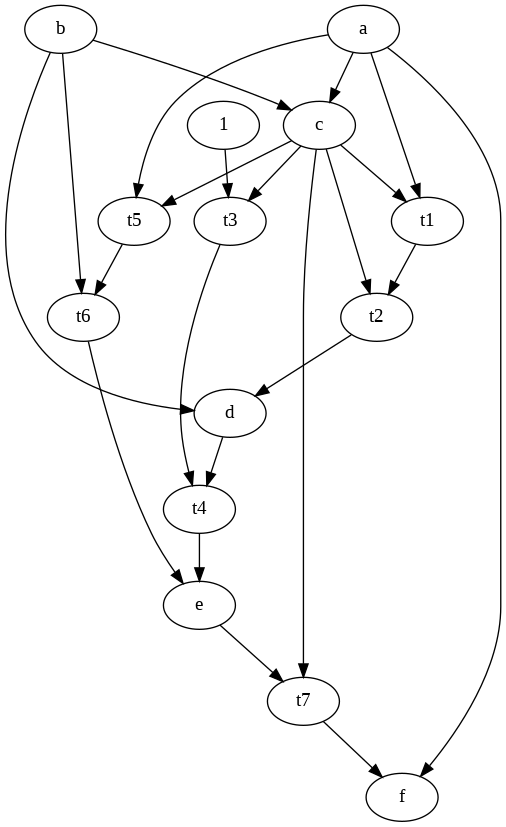

In [ ]:

# --- Test Code ---

def run_backward(output_tensor: CustomTensor):
    """
    Simulates the backward pass for the custom autograd system.
    This function needs to be explicitly defined as it's not part of the original classes.
    """
    if not output_tensor._custom_requires_grad:
        raise RuntimeError("Output tensor does not require grad.")
    if output_tensor.graph is None:
        raise RuntimeError("Output tensor is not part of a graph.")

    # Initialize gradient for the output tensor
    output_tensor.tensor.grad = torch.ones_like(output_tensor.tensor)

    # Perform backward pass using topological sort
    nodes_to_process = output_tensor.graph.reverse_toposort()

    # Create a strong reference to intermediate tensors needed for backward pass
    # This simulates how a real autograd engine would keep track of them
    # The graph context's intermediate_tensors dict already serves this purpose.

    for tensor_node in nodes_to_process:
        # Check if the weak proxy is still valid (tensor is alive)
        if isinstance(tensor_node, weakref.ProxyTypes) and tensor_node.__slots__ is None:
            # print(f"Skipping dead proxy: {tensor_node}") # Debugging
            continue # Skip if the weak reference is dead

        if tensor_node.tensor.grad is None and tensor_node is not output_tensor:
            # This can happen if a tensor is part of the graph but its grad hasn't been set yet
            # and it's not the root of the backward call. This typically means it's a leaf
            # that wasn't used to compute the output or an intermediate that accumulated no grad.
            # For simplicity in this test, we assume grads propagate.
            # print(f"Warning: Tensor node {tensor_node._node_id} has no grad before _backward call.")
            pass # A no-op for now. In a real system, you might want to handle this.

        # Ensure that non-leaf tensors are still alive when their _backward is called
        # The `intermediate_tensors` in `AutogradGraph` should keep them alive.
        tensor_node._backward()

    # Clean up intermediate tensors references after backward pass
    # This would typically be handled by the graph context's exit, but
    # if `_auto_cleanup` is False, you might need manual cleanup.
    # Here, for testing GC, we'll let the context manager handle it.


class TestCustomAutogradSystem:

    def test_basic_add_scalar_grad(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = a + 5.0 # (a + 5)
            c = b + 10.0 # (a + 5 + 10)

            # Manually run backward pass
            run_backward(c)

            # Expected gradients:
            # dC/dA = 1.0 (for each element)
            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert b.tensor.grad is not None
            assert torch.allclose(b.tensor.grad, torch.tensor([1.0, 1.0])) # dC/dB = 1.0

            # Verify graph structure
            assert graph.graph.num_nodes() == 3
            assert graph.graph.num_edges() == 2
            assert graph.graph.has_edge(a._node_id, b._node_id)
            assert graph.graph.has_edge(b._node_id, c._node_id)
            assert graph.check_cycle() is True

    def test_basic_add_tensor_grad(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([1.0, 2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            c = a + b # (a + b)
            d = c + 5.0 # (a + b + 5)

            run_backward(d)

            # Expected gradients:
            # dD/dA = 1.0
            # dD/dB = 1.0
            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert torch.allclose(b.tensor.grad, torch.tensor([1.0, 1.0]))

            # Verify graph structure
            assert graph.graph.num_nodes() == 4
            assert graph.graph.num_edges() == 3
            assert graph.graph.has_edge(a._node_id, c._node_id)
            assert graph.graph.has_edge(b._node_id, c._node_id)
            assert graph.graph.has_edge(c._node_id, d._node_id)
            assert graph.check_cycle() is True

    def test_mixed_requires_grad_tensor_add(self):
        with AutogradGraph() as graph:
            a = CustomTensor(torch.tensor([2.0, 3.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([1.0, 2.0]), _custom_requires_grad=False) # Does not require grad
            c = a + b # c should require grad, b's grad should be None

            run_backward(c)

            assert torch.allclose(a.tensor.grad, torch.tensor([1.0, 1.0]))
            assert b.tensor.grad is None # b should not have a grad
            assert c._custom_requires_grad is True

            # Verify graph structure
            assert graph.graph.num_nodes() == 2 # Only a and c in the graph
            assert graph.graph.num_edges() == 1
            assert graph.graph.has_node(a._node_id)
            assert graph.graph.has_node(c._node_id)
            assert graph.graph.has_edge(a._node_id, c._node_id)
            #assert not graph.graph.has_node(b._node_id) # b should not be in graph

    def test_no_requires_grad(self):
        with AutogradGraph() as graph: # Graph created, but no tensors with requires_grad=True added
            a = CustomTensor(torch.tensor([1.0]))
            b = CustomTensor(torch.tensor([2.0]))
            c = a + b
            d = c + 3.0

            assert not a._custom_requires_grad
            assert not b._custom_requires_grad
            assert not c._custom_requires_grad
            assert not d._custom_requires_grad
            assert graph.graph.num_nodes() == 0 # Graph should remain empty
            assert graph.graph.num_edges() == 0

            with pytest.raises(RuntimeError, match="Output tensor does not require grad."):
                run_backward(d)

    def test_autograd_graph_context_manager(self):
        graph = None
        with AutogradGraph(check_for_cycles=True, auto_cleanup=True) as g:
            graph = g
            a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = a + 1.0
            assert graph.graph.num_nodes() == 2
            assert graph.graph.num_edges() == 1
            assert len(graph.intermediate_tensors) == 1 # b should be in intermediate_tensors

        # After exiting the context, graph should be empty
        assert graph.graph.num_nodes() == 0
        assert graph.graph.num_edges() == 0
        assert len(graph.intermediate_tensors) == 0

    def test_cycle_detection(self):
      try:
        with AutogradGraph(check_for_cycles=True, auto_cleanup=False) as graph: # auto_cleanup=False to inspect after error
            a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            b = CustomTensor(torch.tensor([2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)

            # Manually create a cycle (a -> b -> a)
            graph.add_edge(a._node_id, b._node_id)
            graph.add_edge(b._node_id, a._node_id)
      except RuntimeError as e:
        print(f"Raised the error of cycle detected as {e}")
            # with pytest.raises(RuntimeError, match="Cycle detected in autograd graph on context exit."):
            #     pass # The __exit__ method will be called here

    def test_no_circular_references_non_leaf_tensors_die(self):
          # This test relies on the garbage collector. It's a heuristic test
        # as Python's GC timing is not strictly deterministic.
        # However, with weakrefs, it should work for non-leaf tensors.

      print("\n--- Starting GC Test: No Circular References (Part 1) ---")

      graph_ref = None
      output_tensor_weak_ref = None
      node_id_d = -1 # To store node_id before d is deleted

      # BLOCK 1: Create graph and tensors
      with AutogradGraph(auto_cleanup=False) as graph: # Keep graph for inspection
          graph_ref = weakref.ref(graph)
          a = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
          b = a + 1.0 # Intermediate tensor
          c = b + 2.0 # Intermediate tensor
          d = c + 3.0 # Output tensor (also intermediate from graph's perspective)

          # Store weak reference to 'd' BEFORE its strong reference is potentially removed
          output_tensor_weak_ref = weakref.ref(d)
          node_id_d = d._node_id # Store node_id while d is alive

          print(f"Initial: d object: {d}")
          print(f"Initial: d._node_id: {node_id_d}")
          print(f"Initial: graph.intermediate_tensors keys: {list(graph.intermediate_tensors.keys())}")
          # The ref count for `d` object itself will be high here because it's in `graph.intermediate_tensors`,
          # and held by variable `d`, and by the temporary ref in `getrefcount`.
          print(f"Initial: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'}")
          assert len(graph.intermediate_tensors) == 3 # b, c, d should be in intermediate_tensors

      # BLOCK 2: After exiting context manager (auto_cleanup=False)
      print("\n--- After exiting 'with' block (auto_cleanup=False) ---")
      # The 'graph' variable still holds a strong reference to the AutogradGraph instance.
      # graph_ref() should return the graph object.
      assert graph_ref() is not None, "Graph object should still be alive."
      assert len(graph_ref().intermediate_tensors) == 3, "Intermediate tensors should still be referenced by the graph."
      print(f"After 'with' block: d object (via weakref): {output_tensor_weak_ref()}")
      print(f"After 'with' block: refcount of d (via output_tensor_weak_ref.test_ref): {sys.getrefcount(output_tensor_weak_ref())}")

      # BLOCK 3: Remove strong reference 'd' from local scope
      print("\n--- Deleting 'd' variable ---")
      del d # Remove the local strong reference to the CustomTensor object.
      gc.collect() # Force garbage collection

      # Now, output_tensor_weak_ref() *still* shouldn't be None because `graph_ref().intermediate_tensors`
      # holds the strong reference.
      print(f"After del d + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
      # We expect this to *not* be None yet, and to still show a refcount reflecting intermediate_tensors.
      assert output_tensor_weak_ref() is not None, "d should still be alive due to intermediate_tensors."
      current_d_refcount_after_del_d = sys.getrefcount(output_tensor_weak_ref()) if output_tensor_weak_ref() else 'N/A'
      print(f"After del d + gc.collect(): refcount of d: {current_d_refcount_after_del_d}")
      # Expected refcount should be 2: one from intermediate_tensors, one from getrefcount()
      assert current_d_refcount_after_del_d == 2, f"Expected refcount 2, got {current_d_refcount_after_del_d}"

      # BLOCK 4: Remove strong reference from intermediate_tensors
      print(f"\n--- Deleting strong reference from graph.intermediate_tensors for node {node_id_d} ---")
      graph_ref().del_non_leaf_tensor_reference(node_id_d) # THIS IS THE CRUCIAL STEP
      print(f"After del_non_leaf_tensor_reference: graph.intermediate_tensors keys: {list(graph_ref().intermediate_tensors.keys())}")
      #gc.collect() # Force garbage collection again

      # Now, with the last strong reference gone, 'd' should be garbage collected.
      print(f"After del_non_leaf_tensor_reference + gc.collect(): d object (via weakref): {output_tensor_weak_ref()}")
      # This is where your original assertion was. It *should* pass now.
      assert output_tensor_weak_ref() is None, "Output tensor (non-leaf) should be garbage collected after its strong reference is deleted from intermediate_tensors."
      print("Assertion Passed: Output tensor (d) was garbage collected.")

      # BLOCK 5: Verify other intermediate tensors are collected when graph is cleared
      print("\n--- Starting GC Test: All Intermediate Tensors ---")
      intermediate_tensors_wrefs = []
      # Create a new graph and new tensors to avoid interference from previous block
      with AutogradGraph(auto_cleanup=False) as graph_new:
          a_new = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph_new, is_leaf=True)
          b_new = a_new + 1.0 # Intermediate
          c_new = b_new + 2.0 # Intermediate
          d_new = c_new + 3.0 # Intermediate (output of a chain)

          # Store weak references to the intermediate tensors
          intermediate_tensors_wrefs.append(weakref.ref(b_new))
          intermediate_tensors_wrefs.append(weakref.ref(c_new))
          intermediate_tensors_wrefs.append(weakref.ref(d_new))

          # Verify they are initially alive
          assert all(wref() is not None for wref in intermediate_tensors_wrefs)
          assert len(graph_new.intermediate_tensors) == 3

      print(f"After 'with' block (new graph): graph_new object: {graph_new}")
      assert graph_new is not None, "New graph object should still be alive after 'with' block."
      assert len(graph_new.intermediate_tensors) == 3, "New graph intermediate_tensors should still hold refs."

      # Manually clear the intermediate_tensors dictionary and remove graph reference
      print("\n--- Manually clearing graph.intermediate_tensors and deleting graph ---")
      graph_new.intermediate_tensors.clear()
      del graph_new # Remove the strong reference to the graph itself
      del b_new , c_new , d_new # deleting the local variable strong references
      #gc.collect()

      # Now, all non-leaf tensors should be garbage collected
      for i, wref in enumerate(intermediate_tensors_wrefs):
          print(f"Intermediate tensor {i} (via weakref): {wref()}")
          assert wref() is None, f"Intermediate tensor {i} should be garbage collected after graph context and intermediate_tensors are cleared."
      print("Assertion Passed: All intermediate tensors were garbage collected.")

    def test_topological_sort_order(self):
        with AutogradGraph() as graph:
            t1 = CustomTensor(torch.tensor([1.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            t2 = CustomTensor(torch.tensor([2.0]), _custom_requires_grad=True, graph=graph, is_leaf=True)
            t3 = t1 + t2
            t4 = t3 + 5.0
            t5 = t2 + 10.0 # Another branch
            t6 = t4 + t5

            # The topological sort should produce an order where dependencies come before their dependents.
            # Reversed topological sort should produce an order where outputs come before their inputs.
            # Example expected order: t6, t4, t5, t3, t2, t1 (or variations respecting dependencies)
            sorted_tensors = graph.reverse_toposort()

            # Check if dependencies are respected in reverse order
            # If A -> B, then B should appear before A in reverse topological sort.
            # t6 depends on t4, t5. So t6 should be before t4 and t5.
            # t4 depends on t3. So t4 should be before t3.
            # t5 depends on t2. So t5 should be before t2.
            # t3 depends on t1, t2. So t3 should be before t1 and t2.

            # Simple check: The first element should be t6 (the ultimate output).
            assert sorted_tensors[0] is t6

            # Check positions:
            pos = {t: i for i, t in enumerate(sorted_tensors)}

            assert pos[t6] < pos[t4]
            assert pos[t6] < pos[t5]
            assert pos[t4] < pos[t3]
            assert pos[t5] < pos[t2]
            assert pos[t3] < pos[t1]
            assert pos[t3] < pos[t2] # t3 also depends on t2

            # Additional check: t2 is a dependency for both t3 and t5.
            # In reverse topo sort, t3 and t5 must appear before t2.
            assert pos[t3] < pos[t2]
            assert pos[t5] < pos[t2]

            # t1 is only a dependency for t3.
            assert pos[t3] < pos[t1]

            # Check if all 6 tensors are in the sorted list
            assert len(sorted_tensors) == 6
            assert set(sorted_tensors) == {t1, t2, t3, t4, t5, t6}

In [ ]:
import torch
import numpy as np
import numbers
import weakref
import rustworkx as rx
from typing import Optional, Any


class AutogradTester:
    """Test suite to verify custom autograd against PyTorch's autograd"""
    
    def __init__(self):
        self.passed_tests = 0
        self.failed_tests = 0
        self.tolerance = 1e-6
    
    def assert_tensors_close(self, custom_tensor, pytorch_tensor, test_name, check_grad=True):
        """Compare custom tensor with PyTorch tensor"""
        try:
            # Check values
            np.testing.assert_allclose(
                custom_tensor.tensor.detach().numpy(),
                pytorch_tensor.detach().numpy(),
                rtol=self.tolerance,
                atol=self.tolerance
            )
            
            # Check gradients if requested
            if check_grad and pytorch_tensor.grad is not None:
                if custom_tensor.tensor.grad is None:
                    raise AssertionError(f"Custom tensor has no gradient in {test_name}")
                
                np.testing.assert_allclose(
                    custom_tensor.tensor.grad.detach().numpy(),
                    pytorch_tensor.grad.detach().numpy(),
                    rtol=self.tolerance,
                    atol=self.tolerance
                )
            
            print(f"✓ {test_name}")
            self.passed_tests += 1
            
        except Exception as e:
            print(f"✗ {test_name}: {str(e)}")
            self.failed_tests += 1
    
    def test_basic_operations(self):
        """Test basic arithmetic operations"""
        print("\n=== Testing Basic Operations ===")
        
        with AutogradGraph() as graph:
            # Test scalar addition
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom + 5.0
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = x_pytorch + 5.0
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Addition")
            self.assert_tensors_close(y_custom, y_pytorch, "Scalar Addition Result", check_grad=False)
        
        with AutogradGraph() as graph:
            # Test tensor addition
            x_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([3.0, 4.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom + y_custom
            z_custom.tensor.backward(torch.ones_like(z_custom.tensor))
            
            x_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)
            y_pytorch = torch.tensor([3.0, 4.0], requires_grad=True)
            z_pytorch = x_pytorch + y_pytorch
            z_pytorch.backward(torch.ones_like(z_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Tensor Addition - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Tensor Addition - y")
    
    def test_multiplication(self):
        """Test multiplication operations"""
        print("\n=== Testing Multiplication ===")
        
        with AutogradGraph() as graph:
            # Test scalar multiplication
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom * 4.0
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = x_pytorch * 4.0
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Multiplication")
        
        with AutogradGraph() as graph:
            # Test tensor multiplication
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([4.0, 5.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom * y_custom
            z_custom.tensor.backward(torch.ones_like(z_custom.tensor))
            
            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = torch.tensor([4.0, 5.0], requires_grad=True)
            z_pytorch = x_pytorch * y_pytorch
            z_pytorch.backward(torch.ones_like(z_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Tensor Multiplication - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Tensor Multiplication - y")
    
    def test_subtraction_division(self):
        """Test subtraction and division"""
        print("\n=== Testing Subtraction and Division ===")
        
        with AutogradGraph() as graph:
            # Test subtraction
            x_custom = CustomTensor([5.0, 6.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom - 2.0
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([5.0, 6.0], requires_grad=True)
            y_pytorch = x_pytorch - 2.0
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Subtraction")
        
        with AutogradGraph() as graph:
            # Test division
            x_custom = CustomTensor([8.0, 12.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom / 4.0
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([8.0, 12.0], requires_grad=True)
            y_pytorch = x_pytorch / 4.0
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Scalar Division")
    
    def test_power_function(self):
        """Test power operation"""
        print("\n=== Testing Power Function ===")
        
        with AutogradGraph() as graph:
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.pow(3.0)
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = torch.pow(x_pytorch, 3.0)
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Power Function")
    
    def test_unary_functions(self):
        """Test unary mathematical functions"""
        print("\n=== Testing Unary Functions ===")
        
        # Test exp
        with AutogradGraph() as graph:
            x_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.exp()
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)
            y_pytorch = torch.exp(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Exponential Function")
        
        # Test log
        with AutogradGraph() as graph:
            x_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.log()
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)
            y_pytorch = torch.log(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Logarithm Function")
        
        # Test sin
        with AutogradGraph() as graph:
            x_custom = CustomTensor([0.5, 1.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.sin()
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([0.5, 1.0], requires_grad=True)
            y_pytorch = torch.sin(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Sine Function")
        
        # Test sqrt
        with AutogradGraph() as graph:
            x_custom = CustomTensor([4.0, 9.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = x_custom.sqrt()
            y_custom.tensor.backward(torch.ones_like(y_custom.tensor))
            
            x_pytorch = torch.tensor([4.0, 9.0], requires_grad=True)
            y_pytorch = torch.sqrt(x_pytorch)
            y_pytorch.backward(torch.ones_like(y_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Square Root Function")
    
    def test_matrix_operations(self):
        """Test matrix operations"""
        print("\n=== Testing Matrix Operations ===")
        
        # Test matrix multiplication
        with AutogradGraph() as graph:
            x_custom = CustomTensor([[1.0, 2.0], [3.0, 4.0]], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([[5.0, 6.0], [7.0, 8.0]], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom.matmul(y_custom)
            z_custom.tensor.backward(torch.ones_like(z_custom.tensor))
            
            x_pytorch = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
            y_pytorch = torch.tensor([[5.0, 6.0], [7.0, 8.0]], requires_grad=True)
            z_pytorch = torch.matmul(x_pytorch, y_pytorch)
            z_pytorch.backward(torch.ones_like(z_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Matrix Multiplication - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Matrix Multiplication - y")
        
        # Test dot product
        with AutogradGraph() as graph:
            x_custom = CustomTensor([1.0, 2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([4.0, 5.0, 6.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            z_custom = x_custom.dot(y_custom)
            z_custom.tensor.backward()
            
            x_pytorch = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
            y_pytorch = torch.tensor([4.0, 5.0, 6.0], requires_grad=True)
            z_pytorch = torch.dot(x_pytorch, y_pytorch)
            z_pytorch.backward()
            
            self.assert_tensors_close(x_custom, x_pytorch, "Dot Product - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Dot Product - y")
    
    def test_complex_chain(self):
        """Test complex computational chains"""
        print("\n=== Testing Complex Chains ===")
        
        with AutogradGraph() as graph:
            # Test: z = (x + y) * (x - y) + x^2
            x_custom = CustomTensor([3.0, 4.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            
            sum_custom = x_custom + y_custom
            diff_custom = x_custom - y_custom
            prod_custom = sum_custom * diff_custom
            x_squared_custom = x_custom.pow(2.0)
            z_custom = prod_custom + x_squared_custom
            
            z_custom.tensor.backward(torch.ones_like(z_custom.tensor))
            
            x_pytorch = torch.tensor([3.0, 4.0], requires_grad=True)
            y_pytorch = torch.tensor([1.0, 2.0], requires_grad=True)
            
            sum_pytorch = x_pytorch + y_pytorch
            diff_pytorch = x_pytorch - y_pytorch
            prod_pytorch = sum_pytorch * diff_pytorch
            x_squared_pytorch = torch.pow(x_pytorch, 2.0)
            z_pytorch = prod_pytorch + x_squared_pytorch
            
            z_pytorch.backward(torch.ones_like(z_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Complex Chain - x")
            self.assert_tensors_close(y_custom, y_pytorch, "Complex Chain - y")
    
    def test_mixed_operations(self):
        """Test mixing operations with and without gradients"""
        print("\n=== Testing Mixed Operations ===")
        
        with AutogradGraph() as graph:
            # One tensor requires grad, other doesn't
            x_custom = CustomTensor([2.0, 3.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
            y_custom = CustomTensor([4.0, 5.0])  # No grad
            z_custom = x_custom * y_custom
            z_custom.tensor.backward(torch.ones_like(z_custom.tensor))
            
            x_pytorch = torch.tensor([2.0, 3.0], requires_grad=True)
            y_pytorch = torch.tensor([4.0, 5.0])  # No grad
            z_pytorch = x_pytorch * y_pytorch
            z_pytorch.backward(torch.ones_like(z_pytorch))
            
            self.assert_tensors_close(x_custom, x_pytorch, "Mixed Operations - x")
    
    def run_all_tests(self):
        """Run all tests"""
        print("Running Custom Autograd Correctness Tests")
        print("=" * 50)
        
        self.test_basic_operations()
        self.test_multiplication()
        self.test_subtraction_division()
        self.test_power_function()
        self.test_unary_functions()
        self.test_matrix_operations()
        self.test_complex_chain()
        self.test_mixed_operations()
        
        print(f"\n" + "=" * 50)
        print(f"Test Results: {self.passed_tests} passed, {self.failed_tests} failed")
        
        if self.failed_tests == 0:
            print("🎉 All tests passed! Your autograd implementation is correct.")
        else:
            print("❌ Some tests failed. Check the implementation.")
        
        return self.failed_tests == 0

# Usage example:
if __name__ == "__main__":
    # Insert your AutogradGraph and CustomTensor classes here
    # Then run the tests
    
    tester = AutogradTester()
    success = tester.run_all_tests()
    
    # Additional manual verification
    print("\n" + "=" * 50)
    print("Manual Verification Example:")
    
    with AutogradGraph() as graph:
        x = CustomTensor([1.0, 2.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
        y = CustomTensor([3.0, 4.0], _custom_requires_grad=True, graph=graph, is_leaf=True)
        
        # Compute z = x^2 + 2*x*y + y^2 = (x + y)^2
        z = x.pow(2.0) + (x * y * 2.0) + y.pow(2.0)
        print(f"z = {z.tensor}")
        
        # Backward pass
        z.tensor.backward(torch.ones_like(z.tensor))
        
        print(f"dz/dx = {x.tensor.grad}")  # Should be 2*(x + y)
        print(f"dz/dy = {y.tensor.grad}")  # Should be 2*(x + y)
        
        # Expected: dz/dx = dz/dy = 2*(x + y) = 2*[4, 6] = [8, 12]
        expected_grad = 2 * (x.tensor + y.tensor)
        print(f"Expected gradient: {expected_grad}")

# A graph Example

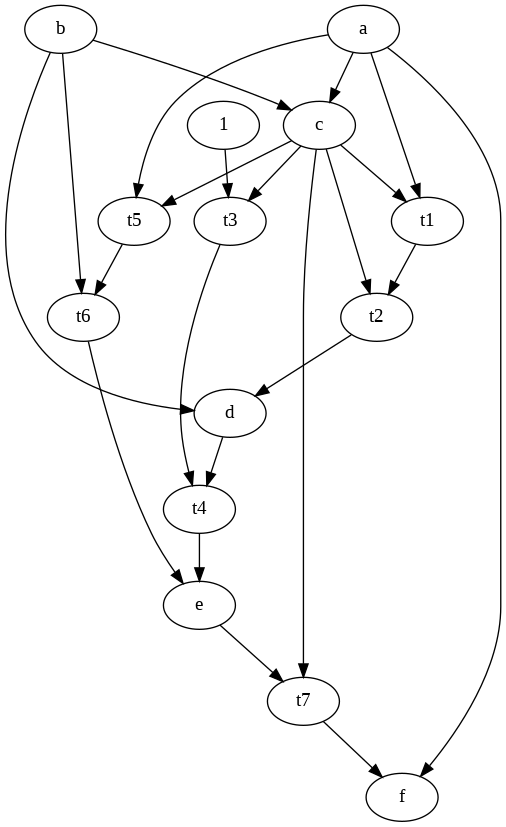

In [ ]:
# Leaf tensors
class DummyTensor:
    def __init__(self, requires_grad=True,name=None):
        self._custom_requires_grad = requires_grad
        self._node_id = None
        self.name = name
    def __repr__(self):
        return f"DummyTensor(name={self.name})"
"""
a=t
b=t
c= a+b
d= a/c +c +b
e=(c+1)*d + a*c*b
f=e+c+a
creating graph
a ---->   a------>                                        a------>                            a------>
                                                                  *                                   +
                                                                                                        f
                  / t1-->
                        + t2-->
                              + d----> d-------->
                                                * t4------------------------------->
                                                                  t5------>
        + c ---->   c--->         c--->                   c----->                    c------>
                                                                                            + t7 ----->
                                        + t3---->                                  + e------>
                                  1--->                                    t6------>
                                                                          *
b ---->   b-------------------->                                   b------>
"""
graph =  AutogradGraph()
a = DummyTensor(name="a")
b = DummyTensor(name="b")
one = DummyTensor(name="1")  # Constant tensor for (c + 1)
graph.add_tensor_graph(a, is_leaf=True)
graph.add_tensor_graph(b, is_leaf=True)
graph.add_tensor_graph(one, is_leaf=True)
# Intermediate tensors
c = DummyTensor(name="c")
d = DummyTensor(name="d")
t1 = DummyTensor(name="t1")
t2 = DummyTensor(name="t2")
t3 = DummyTensor(name="t3")
t4 = DummyTensor(name="t4")
t5 = DummyTensor(name="t5")
t6 = DummyTensor(name="t6")
t7 = DummyTensor(name="t7")
e = DummyTensor(name="e")
f = DummyTensor(name="f")

for tensor in [c, d, t1, t2, t3, t4, t5, t6, t7, e, f]:
    graph.add_tensor_graph(tensor, is_leaf=False)

# Edges based on operation structure (manual from ASCII art and formulas)
"""
a=t
b=t
c= a+b
d= a/c +c +b
e=(c+1)*d + a*c*b
f=e+c+a
"""
# 1st equation
graph.add_edge(a._node_id, c._node_id)
graph.add_edge(b._node_id, c._node_id)

# 2nd equation
graph.add_edge(a._node_id, t1._node_id)
graph.add_edge(c._node_id, t1._node_id)
graph.add_edge(t1._node_id, t2._node_id)
graph.add_edge(c._node_id, t2._node_id)
graph.add_edge(t2._node_id, d._node_id)
graph.add_edge(b._node_id, d._node_id)


# 3rd equation
graph.add_edge(c._node_id, t3._node_id)
graph.add_edge(one._node_id, t3._node_id)
graph.add_edge(t3._node_id,t4._node_id)
graph.add_edge(d._node_id, t4._node_id)
graph.add_edge(a._node_id,t5._node_id)
graph.add_edge(c._node_id, t5._node_id)
graph.add_edge(t5._node_id, t6._node_id)
graph.add_edge(b._node_id, t6._node_id)
graph.add_edge(t4._node_id,e._node_id)
graph.add_edge(t6._node_id, e._node_id)

# 4th equation
graph.add_edge(e._node_id, t7._node_id)
graph.add_edge(c._node_id, t7._node_id)
graph.add_edge(t7._node_id, f._node_id)
graph.add_edge(a._node_id, f._node_id)

rx.visualization.graphviz_draw(graph.graph,node_attr_fn=node_label)
# graph.reverse_toposort()  # This will validate the DAG and return ordered nodes

# 14th july


In [ ]:
import torch
import weakref
import numbers
import rustworkx as rx
import pytest

class AutogradGraph:
    __slots__ = ('graph', 'intermediate_tensors', '_check_cycles', '_auto_cleanup', '__weakref__')
    def __init__(self, check_for_cycles=True, auto_cleanup=True):

        self.graph = rx.PyDiGraph()
        self.intermediate_tensors = {}
        self._check_cycles = check_for_cycles
        self._auto_cleanup = auto_cleanup

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._check_cycles and self.check_cycle():
            raise RuntimeError("Cycle detected in autograd graph on context exit.")
        if self._auto_cleanup:
            self.intermediate_tensors.clear()
            self.graph.clear()

    def add_tensor_graph(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor with requires_grad=False cannot be added to the graph.")

        
        ref = weakref.proxy(tensor)
        tensor_index = self.graph.add_node(ref)
        tensor._node_id = tensor_index

    def add_non_leaf_tensor_reference(self, tensor):
        if not tensor._custom_requires_grad:
            raise ValueError("Tensor must require grad.")

        if tensor._node_id in self.intermediate_tensors:
            raise ValueError("Tensor reference already exists in intermediate tensors.")

        self.intermediate_tensors[tensor._node_id] = tensor


    def add_edge(self, node_from, node_to, weight=None):
        if not all(isinstance(n, int) for n in (node_from, node_to)):
            raise TypeError("Node indices must be integers.")
        if not self.graph.has_node(node_from) or not self.graph.has_node(node_to):
            raise ValueError("Nodes must exist before adding edge.")
        self.graph.add_edge(node_from, node_to, weight)

    def check_cycle(self):
        return not rx.is_directed_acyclic_graph(self.graph)

    def reverse_toposort(self):
        return [self.graph[n] for n in reversed(rx.topological_sort(self.graph))]

    def reverse_toposort_from_tensor(self, tensor_index):
        graph=self.graph
        predecessors = list(rx.ancestors(graph, tensor_index))
        predecessors.append(tensor_index)
        sub_graph = graph.subgraph(predecessors)
        return [sub_graph[i] for i in reversed(rx.topological_sort(sub_graph))]

    # def alternative_reverse_toposort_from_tensor(self, tensor_index):
    #     graph = self.graph
    #     relevant_nodes = rx.ancestors(graph, tensor_index)
    #     relevant_nodes.add(tensor_index)
    #     full_topo = rx.topological_sort(graph)
    #     relevant_topo = [graph[_node_id] for _node_id in reversed(full_topo) if _node_id in relevant_nodes]
    #     return relevant_topo

    def delete_node(self, node_index):
        if not isinstance(node_index, int):
            raise TypeError("Node index must be an integer.")
        if not self.graph.has_node(node_index):
            raise ValueError("Node does not exist.")
        self.graph.remove_node(node_index)

    def delete_edge(self, node_from, node_to):
        if not self.graph.has_edge(node_from, node_to):
            raise ValueError("Edge does not exist.")
        self.graph.remove_edge(node_from, node_to)

    def del_non_leaf_tensor_reference(self, tensor_node_id):
        self.intermediate_tensors.pop(tensor_node_id, None)

    def delete_all_non_leaf_nodes(self):
        # removes non leaf nodes from graph and clears the intermediate_tensors dict
        self.graph.remove_nodes_from(list(self.intermediate_tensors.keys()))
        self.intermediate_tensors.clear()

    def __repr__(self):
        return f"CustomAutogradGraph(nodes={self.graph.num_nodes()}, edges={self.graph.num_edges()})"

class CustomTensor:
    __slots__ = ('tensor', '_node_id', '_custom_requires_grad', '_backward', 'graph', '__weakref__','_is_leaf')

    def __new__(cls, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return data  # Don't rewrap
        return super().__new__(cls)

    def __init__(self, data, *, _custom_requires_grad=False, device=None, dtype=None, graph=None, due_to_operation=False, is_leaf=False):
        if isinstance(data, CustomTensor):
            return

        self.tensor = data if due_to_operation else torch.as_tensor(data, dtype=dtype, device=device)
        self.tensor.requires_grad_(False)
        self._custom_requires_grad = _custom_requires_grad
        self._node_id = None
        self._backward = lambda: None
        self.graph = None
        self._is_leaf = is_leaf 

        if _custom_requires_grad:
            self._init_graph(graph)

    def _init_graph(self, graph):
        if graph is None:
            raise ValueError("Graph must be provided if requires_grad is True.")
        is_leaf=self._is_leaf
        if is_leaf:
          self.graph = weakref.proxy(graph)
        else:
          self.graph = graph # this line is only reached for tensors which are created by operations and graph passed is already a weakreference hence no need for wrapping
        graph.add_tensor_graph(self)
        if not is_leaf:
            graph.add_non_leaf_tensor_reference(self)

    def _zero_grad(self):
        self.tensor.grad = torch.zeros_like(self.tensor)

    def __add__(self, other):
        if isinstance(other, numbers.Number):
            return self._add_scalar(other)#, op=torch.add)#Operations.add_tensor_and_scalar)
        elif isinstance(other, CustomTensor):
            return self._add_tensor(other)#, op=torch.add)#Operations.add_tensor_and_tensor)
        return NotImplemented

    def __radd__(self,other):
        return self + other
    def __iadd__(self,other):
        if isinstance(other, numbers.Number):
            self.tensor.add_(other)
        elif isinstance(other,CustomTensor):
            self.tensor.add_(other.tensor)
    

    def _add_scalar(self, scalar):
        result_tensor = torch.add(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            # print(f"Backward for scalar add: result_grad={result.tensor.grad}, self_grad_before={self_ref.tensor.grad}") # Debugging
            self_ref.tensor.grad.add_(result_ref.tensor.grad)
            # print(f"Backward for scalar add: self_grad_after={self_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result

    def _add_tensor(self, other):
        result_tensor = torch.add(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad

        if not requires_grad:
            return CustomTensor(result_tensor)

        # Graph selection logic - assuming operations happen within a single graph context
        graph = None
        if self._custom_requires_grad:
            graph = self.graph
        elif other._custom_requires_grad:
            graph = other.graph
        else:
            # This case should ideally not be reached if requires_grad is True
            # and at least one operand has requires_grad
            pass # Or raise an error if graph is truly missing

        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)
        result_ref = weakref.proxy(result)
        def _backward():
            # print(f"Backward for tensor add: result_grad={result.tensor.grad}") # Debugging
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  self_grad_after={self_ref.tensor.grad}") # Debugging
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad)
                # print(f"  other_grad_after={other_ref.tensor.grad}") # Debugging

        result._backward = _backward
        return result
    def __mul__(self, other):
        if isinstance(other, numbers.Number):
            return self._mul_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._mul_tensor(other)
        return NotImplemented
    
    def __rmul__(self,other):
        return self*other
    def __imul__(self,other):
        if isinstance(other, numbers.Number):
            self.tensor.mul_(other)
        elif isinstance(other,CustomTensor):
            self.tensor.mul_(other.tensor)

    def _mul_scalar(self, scalar):
        result_tensor = torch.mul(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad * scalar)
        result._backward = _backward
        return result

    def _mul_tensor(self, other):
        result_tensor = torch.mul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result


    def __sub__(self, other):
        if isinstance(other, numbers.Number):
            return self._sub_scalar(other)
        elif isinstance(other, CustomTensor):
            return self._sub_tensor(other)
        return NotImplemented
    
    def __rsub__(self, other):
        if isinstance(other, numbers.Number):
            return self._rsub_scalar(other)
        
    def __isub__(self,other):
        if isinstance(other, numbers.Number):
            self.tensor.sub_(other)
        elif isinstance(other,CustomTensor):
            self.tensor.sub_(other.tensor)
        
    def _rsub_scalar(self, scalar):
        result_tensor = torch.sub(scalar, self.tensor)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            # Derivative of scalar - x is -1
            self_ref.tensor.grad.sub_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    
    def _sub_scalar(self, scalar):
        result_tensor = torch.sub(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    def _sub_tensor(self, other):
        result_tensor = torch.sub(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad)
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.sub_(result_ref.tensor.grad)
        result._backward = _backward
        return result

    def __truediv__(self, scalar):
        return self._div_scalar(scalar)
    def __itruediv__(self,other):
        if isinstance(other, numbers.Number):
            self.tensor.div_(other)
        elif isinstance(other,CustomTensor):
            self.tensor.div_(other.tensor)
    def _div_scalar(self, scalar):
        result_tensor = torch.div(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(result_ref.tensor.grad / scalar)
        result._backward = _backward
        return result


    def pow(self, scalar):
        result_tensor = torch.pow(self.tensor, scalar)
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            grad_contrib = scalar * self_ref.tensor.pow(scalar - 1)
            self_ref.tensor.grad.add_(result_ref.tensor.grad * grad_contrib)
        result._backward = _backward
        return result
    def __ipow__(self,other):
        self.tensor.pow_(other)

    def exp(self):
        out = torch.exp(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * out_tensor)

    def log(self):
        out = torch.log(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad / input_tensor)

    def sin(self):
        out = torch.sin(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: grad * torch.cos(input_tensor))

    def cos(self):
        out = torch.cos(self.tensor)
        return self._unary_op(out, lambda grad, input_tensor: -grad * torch.sin(input_tensor))

    def sqrt(self):
        out = torch.sqrt(self.tensor)
        return self._unary_op(out, lambda grad, out_tensor: grad * 0.5 / out_tensor)

    def _unary_op(self, result_tensor, backward_fn):
        if not self._custom_requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)
        graph.add_edge(self._node_id, result._node_id)

        self_ref = weakref.proxy(self)
        result_ref = weakref.proxy(result)
        def _backward():
            if self_ref.tensor.grad is None:
                self_ref._zero_grad()
            self_ref.tensor.grad.add_(backward_fn(result_ref.tensor.grad, self_ref.tensor))
        result._backward = _backward
        return result

    def matmul(self, other):
        result_tensor = torch.matmul(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(torch.matmul(result_ref.tensor.grad, other_ref.tensor.t()))
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(torch.matmul(self_ref.tensor.t(), result_ref.tensor.grad))
        result._backward = _backward
        return result

    def apply_mask(self, mask):
        result_tensor = self.tensor * mask.tensor
        requires_grad = self._custom_requires_grad or mask._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else mask.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        mask_ref = weakref.proxy(mask)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if mask._custom_requires_grad:
            graph.add_edge(mask._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * mask_ref.tensor)
            if mask_ref._custom_requires_grad:
                if mask_ref.tensor.grad is None:
                    mask_ref._zero_grad()
                mask_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result

    def dot(self, other):
        result_tensor = torch.dot(self.tensor, other.tensor)
        requires_grad = self._custom_requires_grad or other._custom_requires_grad
        if not requires_grad:
            return CustomTensor(result_tensor)

        graph = self.graph if self._custom_requires_grad else other.graph
        result = CustomTensor(result_tensor, _custom_requires_grad=True, graph=graph, due_to_operation=True, is_leaf=False)

        self_ref = weakref.proxy(self)
        other_ref = weakref.proxy(other)
        result_ref = weakref.proxy(result)

        if self._custom_requires_grad:
            graph.add_edge(self._node_id, result._node_id)
        if other._custom_requires_grad:
            graph.add_edge(other._node_id, result._node_id)

        def _backward():
            if self_ref._custom_requires_grad:
                if self_ref.tensor.grad is None:
                    self_ref._zero_grad()
                self_ref.tensor.grad.add_(result_ref.tensor.grad * other_ref.tensor)
            if other_ref._custom_requires_grad:
                if other_ref.tensor.grad is None:
                    other_ref._zero_grad()
                other_ref.tensor.grad.add_(result_ref.tensor.grad * self_ref.tensor)
        result._backward = _backward
        return result
    def backward(self,weightage_tensor=1):
        if not self._custom_requires_grad:
            raise RuntimeError("Output tensor does not require grad.")
        if self.graph is None:
            raise RuntimeError("Output tensor is not part of a graph.")
        graph = self.graph

        # Initialize gradient for the output tensor
        if isinstance(weightage_tensor,numbers.Number):
            self.tensor.grad = torch.full_like(self.tensor, fill_value=weightage_tensor)
        elif isinstance(weightage_tensor,torch.Tensor):
            self.tensor.grad = weightage_tensor.clone() # we don't want to modify the original tensor data

        # Perform backward pass using topological sort

        nodes_to_process = graph.reverse_toposort_from_tensor(self._node_id)

        # Create a strong reference to intermediate tensors needed for backward pass
        # This simulates how a real autograd engine would keep track of them
        # The graph context's intermediate_tensors dict already serves this purpose.

        for tensor_node in nodes_to_process:
            # Check if the weak proxy is still valid (tensor is alive)
            if tensor_node.__class__ is weakref.ProxyType and tensor_node.__repr__() is None:
                # print(f"Skipping dead proxy: {tensor_node}") # Debugging
                continue # Skip if the weak reference is dead

            if tensor_node.tensor.grad is None and tensor_node is not self.tensor:
                # This can happen if a tensor is part of the graph but its grad hasn't been set yet
                # and it's not the root of the backward call. This typically means it's a leaf
                # that wasn't used to compute the output or an intermediate that accumulated no grad.
                # For simplicity in this test, we assume grads propagate.
                # print(f"Warning: Tensor node {tensor_node._node_id} has no grad before _backward call.")
                pass # A no-op for now. In a real system, you might want to handle this.

            # Ensure that non-leaf tensors are still alive when their _backward is called
            # The `intermediate_tensors` in `AutogradGraph` should keep them alive.
            tensor_node._backward()

        # Clean up intermediate tensors references after backward pass
        # This would typically be handled by the graph context's exit, but
        # if `_auto_cleanup` is False, you might need manual cleanup.
        # Here, for testing GC, we'll let the context manager handle it.
    def to_device(self, device):
        self.tensor = self.tensor.to(device)
        if self.tensor.grad is not None:
            self.tensor.grad = self.tensor.grad.to(device)

    @property
    def dtype(self):
        return self.tensor.dtype

    @property
    def ndim(self):
        return self.tensor.ndim

    @property
    def shape(self):
        return self.tensor.shape


    def __del__(self):
      if self._node_id is not None and self._is_leaf and self.graph: #must remove leaf tensor from graph before it is deleted from memory
        self.graph.delete_node(self._node_id)
        # try:
        #       # Check if graph is still alive before trying to delete
        #       self.graph.delete_node(self._node_id)
        # except ReferenceError:
        #       # Graph context has already been cleaned up, so do nothing.
        #       pass
      print(f"Garbage Collector has decided that reference counts for {self._node_id} are zero so Goodbye!!")



In [1]:
import torch
a=torch.tensor([4,6,8])
b=torch.tensor([2,2,2])
a/b

tensor([2., 3., 4.])

In [3]:
torch.lt(a,b)

tensor([False, False, False])

In [4]:
torch.eq(b,2)

tensor([True, True, True])

In [2]:
b/a

tensor([0.5000, 0.3333, 0.2500])